# Lab 2: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 9, 2019. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
# I changed the alpha and size parameters to better visualize the plots.
plot_kwds = {'alpha' : 1., 's' : 60, 'linewidths':0}

We will have two toy datasets to try the different methods:

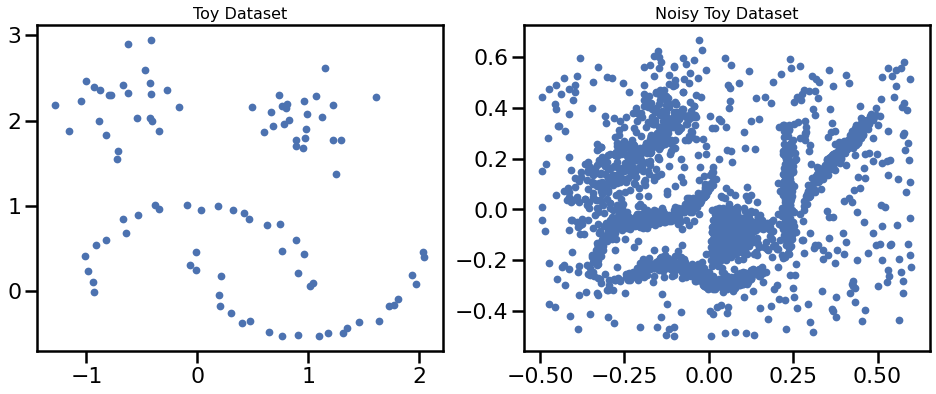

In [3]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

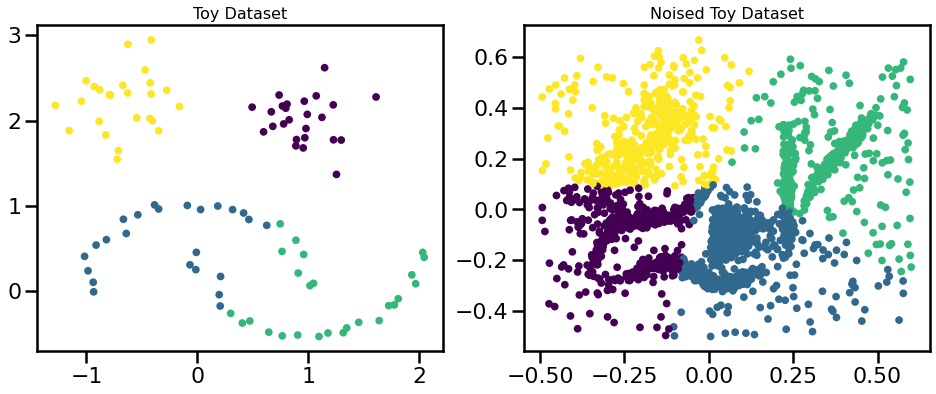

In [4]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [5]:
from scipy.spatial import distance
import tqdm, time

In [18]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None

        self.track_time = True

    def get_distances(self, X):
        distances = distance.cdist(X, X)
        distances_triu = np.triu(distances, k=0)
        distances_triu[np.where(distances_triu == 0.)] = np.inf
        
        return distances_triu

    def get_min_dist(self, distance):
        min_id = np.argmin(distance)
        y, x = min_id%distance.shape[0], min_id//distance.shape[0]

        return x, y, distance[x, y]


    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # if it's not precomputed compute the distance matrix
        # using from scipy.spatial import distance 
        # Calculate distance matrix given observation.

        t0 = time.time()
        self.distances = self.get_distances(X)

        n = self.distances.shape[0]

        self.linkage_matrix_ = np.zeros((n-1, 4)) # Columns are the following : cluster A, cluster B, distance, size of new cluster. 
        self.hierarchy_ = np.zeros((n-1, n)) # Contains snapshots of the labels at each  iteration.
        self.labels_ = list(range(n)) # Initialize labels, each point is initialized as its own cluster.
        self.ref = [[_i] for _i in range(n)] # Reference matrix that maps each component in the distance matrix to its corresponding cluster id.

        m = n # variable m gives the id of the next cluster that will be formed.
        self.t_init = time.time() - t0

        if self.track_time:
            self.col = []
            self.dist = []
            self.data = []
            self.min_ = []

        for i in tqdm.tqdm(range(n-1)):
            t_iter = time.time()
            x, y, d_min = self.get_min_dist(self.distances) # get argmin of distance matrix and the corrsponding points.
            t_min = time.time() - t_iter
            t_iter = time.time()
            
            # We use two columns because this implementation workw with a triangular matrix.
            # Therfore the second part of the new distance vector (where previous elements are set to inf) are obtained by symetry.
            col_1 = np.stack((self.distances[:, y], self.distances[:, x])).T
            col_1 = np.min(col_1, axis = 1)
            col_2 = np.stack((self.distances[y, :], self.distances[x, :])).T
            col_2 = np.min(col_2, axis = 1)
            
            col = np.min(np.stack((col_1, col_2)), axis = 0)
            t_col = time.time() - t_iter
            t_iter = time.time()
            # set the new distances and triangualte the matrix.
            self.distances[x, :] = col
            self.distances[:, x] = col.T

            self.distances[x, :x] = np.inf
            self.distances[x:, x] = np.inf

            # self.distances = np.triu(self.distances, k = 0)

            # This part is probably not necessary.
            # self.distances[np.where(self.distances == 0.)] = np.inf
            # np.fill_diagonal(self.distances, np.inf)
            # self.distances[x, y] = np.inf

            # delete row and column of the element that was merged from the distance matrix.
            # I chose to delete columns/rows instead of adding them at the end to obtain progressively smaller matrices that will be fed to argmin..
            
            
            temp = [t for t in range(self.distances.shape[0]) if t != y]
            self.distances = self.distances[temp, :]
            self.distances = self.distances[:, temp]
            # self.distances = np.delete(self.distances, y, axis = 0)
            # self.distances = np.delete(self.distances, y, axis = 1)
            t_dist = time.time() - t_iter
            t_iter = time.time()
        
            # Add new component to linkage matrix.
            ## self.linkage_matrix_[i] = [self.labels_[self.ref[x][0]], self.labels_[self.ref[y][0]], d_min, len(self.ref[x])]

            pt_1, pt_2 = self.labels_[self.ref[x][0]], self.labels_[self.ref[y][0]]

            # delete merged component from references list.
            self.ref[x] += self.ref[y]
            del self.ref[y]
            
            self.linkage_matrix_[i] = [pt_1, pt_2, d_min, len(self.ref[x])]

            # Update labels using references
            for e in self.ref[x]:
                self.labels_[e] = m
            
            # update index for the next cluster.
            m += 1
            
            # Add labels snapshot to hierarchy.
            self.hierarchy_[i, :] = self.labels_
            t_data = time.time() - t_iter
            if self.track_time:
                self.min_.append(t_min)
                self.col.append(t_col)
                self.dist.append(t_dist)
                self.data.append(t_data)
        print('TIME STATS : (s)')
        print(f' - initialization : {self.t_init}')
        print(f' - min distance search : mean = {np.mean(self.min_)}, total = {np.sum(self.min_)}')
        print(f' - distance column update : mean = {np.mean(self.col)}, total = {np.sum(self.col)}')
        print(f' - distance update : mean = {np.mean(self.dist)}, total = {np.sum(self.dist)}')
        print(f' - data recording : mean = {np.mean(self.data)}, total = {np.sum(self.data)}')    
        return self.hierarchy_

        
def plot_dendrogram(linkage_matrix):
    '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
    to plot the dendrogram of the hierarchical structure
    '''        
    assert linkage_matrix is not None, 'No linkage was found !'
    from scipy.cluster import hierarchy
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = hierarchy.dendrogram(linkage_matrix)
    plt.show()

Apply hierarchical clustering to data from the first dataset and visualize obtained dendrogram.

In [19]:
classif = my_SingleLinkageAglomerativeClustering()

hierarchy = classif.fit(test_data_0)
linkage_mat = classif.linkage_matrix_

100%|██████████| 99/99 [00:00<00:00, 5502.37it/s]

TIME STATS : (s)
 - initialization : 0.001997709274291992
 - min distance search : mean = 3.0168379196012863e-05, total = 0.0029866695404052734
 - distance column update : mean = 6.050774545380563e-05, total = 0.005990266799926758
 - distance update : mean = 7.066582188461766e-05, total = 0.0069959163665771484
 - data recording : mean = 1.0073787034159959e-05, total = 0.000997304916381836


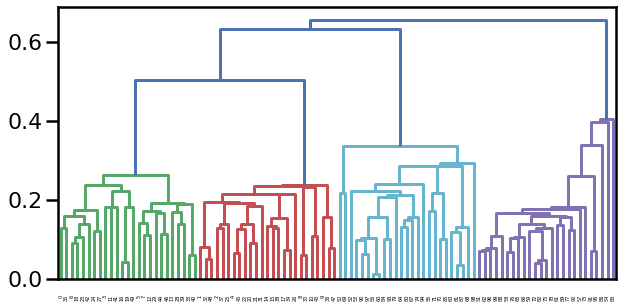

In [20]:
plot_dendrogram(linkage_mat)

Apply hierarchical clustering to data from the second set.

In [21]:
classif_2 = my_SingleLinkageAglomerativeClustering()

hierarchy_2 = classif_2.fit(test_data_1)
linkage_mat_2 = classif_2.linkage_matrix_

100%|██████████| 2308/2308 [02:31<00:00, 15.25it/s] 

TIME STATS : (s)
 - initialization : 0.4960758686065674
 - min distance search : mean = 0.02353539913117989, total = 54.319701194763184
 - distance column update : mean = 0.0002842475264696356, total = 0.656043291091919
 - distance update : mean = 0.04089683676509758, total = 94.38989925384521
 - data recording : mean = 0.00022226055532022408, total = 0.5129773616790771


Hence the calculation time is mainly determined by the minimum distance search and the update of the distance matrix, other methods using slicing can be experimented with to further speedup the algorithm.

ELbow plots for both datasets in order to choose which point to work with.

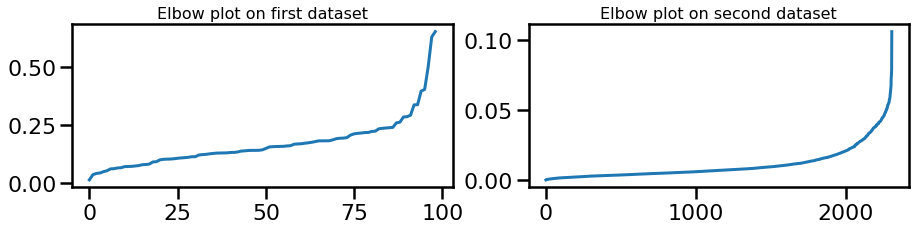

In [22]:
ref_1 = classif.linkage_matrix_
ref_2  = classif_2.linkage_matrix_

fig, ax = plt.subplots(1, 2, figsize = (15, 3))
ax[0].plot(ref_1[:, 2])
ax[0].set_title('Elbow plot on first dataset', size=16)

ax[1].plot(ref_2[:, 2])
ax[1].set_title('Elbow plot on second dataset', size=16)

plt.show()

Visualize results for both datasets after choosing a certain elbow value.

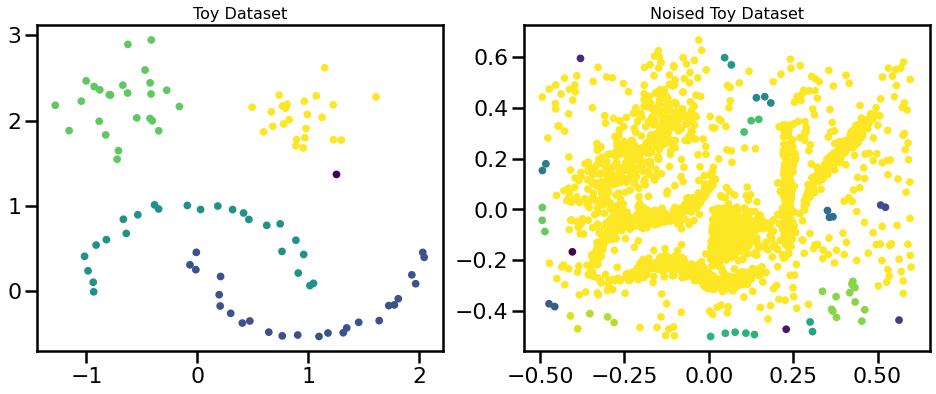

In [23]:
elbow_1 = 94
elbow_2 = 2290
labels = hierarchy[elbow_1, :]

colors = np.unique(labels)
for _i, color in enumerate(colors):
    labels[np.where(labels == color)] = _i

x, y = linkage_mat[elbow_1, [0, 1]].astype(int)
labels_2 = hierarchy_2[elbow_2, :]

colors_2 = np.unique(labels_2)
for _i, color in enumerate(colors_2):
    labels_2[np.where(labels_2 == color)] = _i


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=labels , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)
# ax[0].plot(test_data_0.T[0][[x, y]], test_data_0.T[1][[x, y]])

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=labels_2, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)
# plt.savefig('./test/img_%.3d.jpg'%h)
# plt.close()
plt.show();

We can compare the hierarchies and dendrograms we obtained with those given by ```scipy.cluster.hierarchy.linkage``` and ```scipy.cluster.hierarchy.dendrogram``` to make sure our results are correct.

Hierarchy : 
[[7.00000000e+00 1.60000000e+01 6.28857725e-03 2.00000000e+00]
 [6.00000000e+00 1.00000000e+01 6.31252265e-03 2.00000000e+00]
 [1.50000000e+01 1.90000000e+01 8.55137253e-03 2.00000000e+00]
 [1.10000000e+01 1.80000000e+01 1.13245990e-02 2.00000000e+00]
 [9.00000000e+00 1.40000000e+01 1.23128475e-02 2.00000000e+00]
 [5.00000000e+00 2.10000000e+01 1.39807020e-02 3.00000000e+00]
 [0.00000000e+00 2.30000000e+01 1.66996867e-02 3.00000000e+00]
 [1.30000000e+01 2.00000000e+01 1.74609867e-02 3.00000000e+00]
 [2.40000000e+01 2.70000000e+01 1.90367023e-02 5.00000000e+00]
 [3.00000000e+00 4.00000000e+00 1.97490513e-02 2.00000000e+00]
 [1.20000000e+01 1.70000000e+01 2.15737823e-02 2.00000000e+00]
 [2.50000000e+01 2.80000000e+01 3.05022217e-02 8.00000000e+00]
 [1.00000000e+00 2.20000000e+01 3.10637289e-02 3.00000000e+00]
 [2.60000000e+01 3.10000000e+01 3.17086480e-02 1.10000000e+01]
 [3.00000000e+01 3.30000000e+01 3.70235620e-02 1.30000000e+01]
 [2.90000000e+01 3.20000000e+01 3.80318835

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [100.0, 100.0, 122.5, 122.5],
  [72.5, 72.5, 111.25, 111.25],
  [42.5, 42.5, 91.875, 91.875],
  [20.0, 20.0, 67.1875, 67.1875],
  [155.0, 155.0, 165.0, 165.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [160.0, 160.0, 182.5, 182.5],
  [145.0, 145.0, 171.25, 171.25],
  [43.59375, 43.59375, 158.125, 158.125],
  [5.0, 5.0, 100.859375, 100.859375]],
 'dcoord': [[0.0, 0.021573782304461483, 0.021573782304461483, 0.0],
  [0.0, 0.01132459899341106, 0.01132459899341106, 0.0],
  [0.0, 0.016699686657613608, 0.016699686657613608, 0.01132459899341106],
  [0.0, 0.006312522646335733, 0.006312522646335733, 0.0],
  [0.0, 0.013980701978610172, 0.013980701978610172, 0.006312522646335733],
  [0.0, 0.012312847469212837, 0.012312847469212837, 

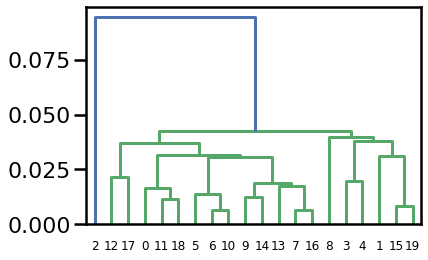

In [24]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(test_data_1[:20], 'single')
print('Hierarchy : ')
print(Z)

print('Dendrogram : ')
dendrogram(Z)

Try the different linkage methods implemented in `sklearn`  and comment

1. For the same number of clusters, these are the results obtained by sklearns ```AgglomerativeClustering``` method.

In [25]:
from sklearn.cluster import AgglomerativeClustering

clusterer_1 = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'single')

data_1 = clusterer_1.fit(test_data_0).labels_

In [26]:
from sklearn.cluster import AgglomerativeClustering

clusterer_2 = AgglomerativeClustering(n_clusters = test_data_1.shape[0] - elbow_2, affinity = 'euclidean', linkage = 'single')

data_2 = clusterer_2.fit(test_data_1).labels_

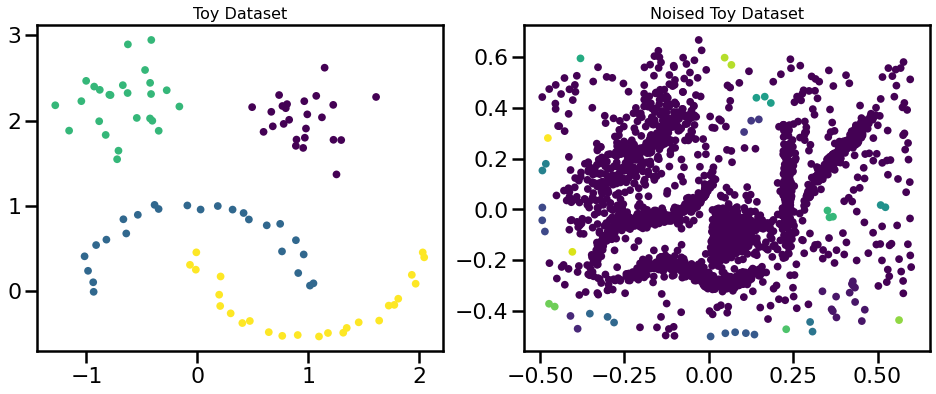

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=data_1 , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=data_2, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

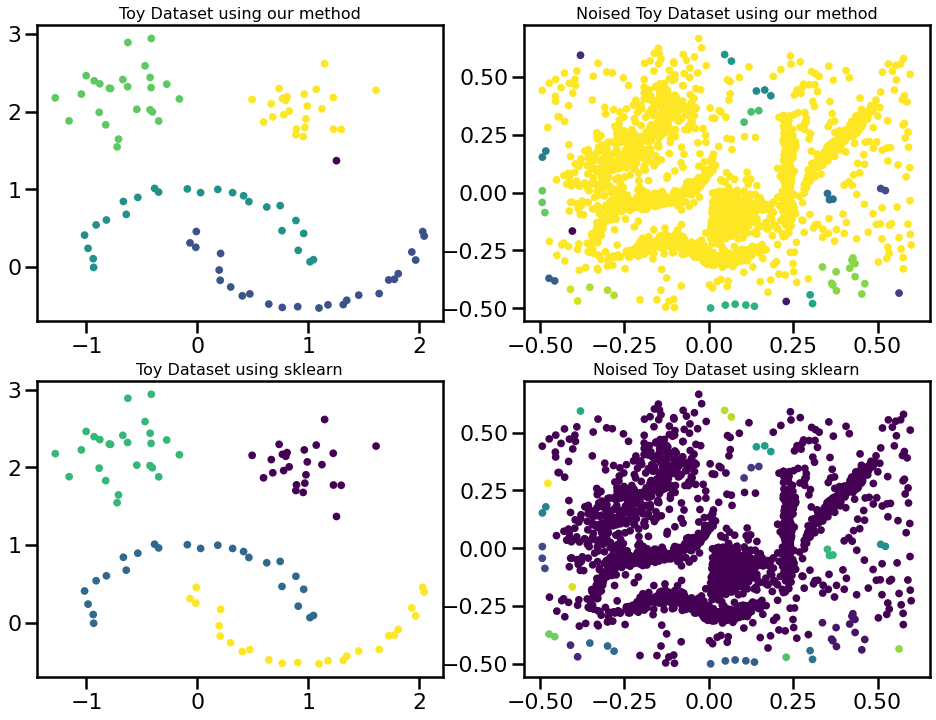

In [28]:
# Comparison

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0][0].scatter(test_data_0.T[0], test_data_0.T[1], c=labels , **plot_kwds)
ax[0][0].set_title('Toy Dataset using our method', size=16)

ax[0][1].scatter(test_data_1.T[0], test_data_1.T[1], c=labels_2, **plot_kwds)
ax[0][1].set_title('Noised Toy Dataset using our method', size=16)

ax[1][0].scatter(test_data_0.T[0], test_data_0.T[1], c=data_1 , **plot_kwds)
ax[1][0].set_title('Toy Dataset using sklearn', size=16)

ax[1][1].scatter(test_data_1.T[0], test_data_1.T[1], c=data_2, **plot_kwds)
ax[1][1].set_title('Noised Toy Dataset using sklearn', size=16)
# ax[1].set_title('using sklearn')
plt.show();

Now let's test different linkage methods on the second dataset.

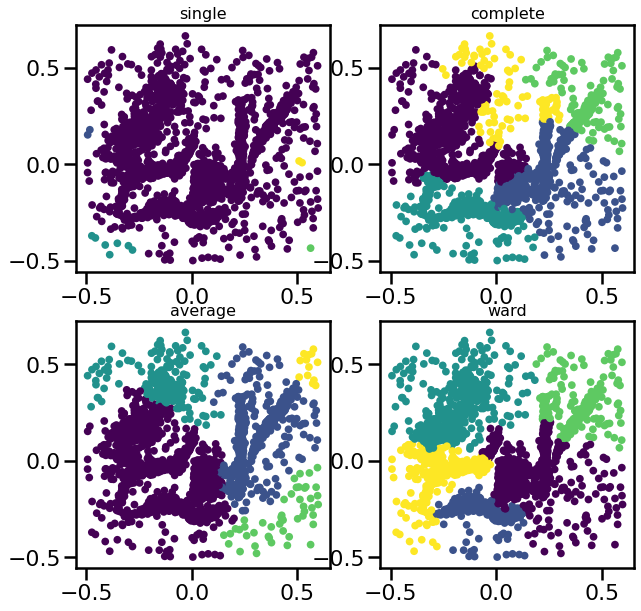

In [17]:
# n_clusters = test_data_1.shape[0] - elbow_2
n_clusters = 5

single = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'single').fit(test_data_1).labels_
complete = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'complete').fit(test_data_1).labels_
average = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'average').fit(test_data_1).labels_
ward = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'ward').fit(test_data_1).labels_

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0][0].scatter(test_data_1.T[0], test_data_1.T[1], c=single , **plot_kwds)
ax[0][0].set_title('single', size=16)

ax[0][1].scatter(test_data_1.T[0], test_data_1.T[1], c=complete, **plot_kwds)
ax[0][1].set_title('complete', size=16)
# ax[0].set_title('')

ax[1][0].scatter(test_data_1.T[0], test_data_1.T[1], c=average , **plot_kwds)
ax[1][0].set_title('average', size=16)

ax[1][1].scatter(test_data_1.T[0], test_data_1.T[1], c=ward, **plot_kwds)
ax[1][1].set_title('ward', size=16)

plt.show()

## Commentary :

Clearly, we can see that the *single* linkage performs the worst and is unable to identify any clear pattern in the datacloud.
Results obtained using *average* linkage are slightly better but still, most of the underlying stucture of the cloud is missed.

Finally, *ward* and *complete* linkages both perform similarly and give better results, but still cannot grasp the patterns completely. 
It seems this is mostly due to the noise points that push clusters to have a higher variance and undermine their silouhettes.

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

## Tuning Epsilon

We can start off by tuning epsilon.

Epsilon is usually approximated by the mean distance of the points to their neighbors, let's calculate it by taking the 10 nearest neighbors of each point.

Text(0, 0.5, 'distance')

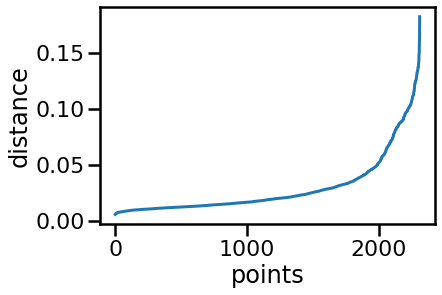

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN


nearest_neighbors = NearestNeighbors(n_neighbors = 11)
neighbors = nearest_neighbors.fit(test_data_1)
distances, indices = neighbors.kneighbors(test_data_1)

distances = np.sort(distances[:, 10], axis = 0)

fig = plt.figure()
plt.plot(distances)
plt.xlabel('points')
plt.ylabel('distance')

So in our case the elbow point appears around **0.04**.

$\epsilon = 0.04$

In [19]:
min_samples = np.linspace(3, 50, 20).astype(int)

for s in min_samples:
    # calculate number of clusters obtained with each trial.
    labels = DBSCAN(eps = 0.04, min_samples = s, metric = 'euclidean').fit(test_data_1).labels_
    n_clusters = len(np.unique(labels))

    # calculate silouhette scores for each trial.
    score = silhouette_score(test_data_1, labels)
    print(f'for min_samples = {s} --> n_clusters = {n_clusters} | silhouette score = {score}')


for min_samples = 3 --> n_clusters = 25 | silhouette score = -0.31385462168985223
for min_samples = 5 --> n_clusters = 10 | silhouette score = -0.42709755455416537
for min_samples = 7 --> n_clusters = 3 | silhouette score = 0.041602558783463604
for min_samples = 10 --> n_clusters = 3 | silhouette score = 0.02326628963394375
for min_samples = 12 --> n_clusters = 5 | silhouette score = 0.15163260183895547
for min_samples = 15 --> n_clusters = 4 | silhouette score = 0.2570002357812019
for min_samples = 17 --> n_clusters = 5 | silhouette score = 0.19145833310716268
for min_samples = 20 --> n_clusters = 6 | silhouette score = 0.23403155189630734
for min_samples = 22 --> n_clusters = 7 | silhouette score = 0.24378516326082778
for min_samples = 25 --> n_clusters = 7 | silhouette score = 0.23360119334392979
for min_samples = 27 --> n_clusters = 7 | silhouette score = 0.22787977890419778
for min_samples = 30 --> n_clusters = 7 | silhouette score = 0.2098889483383456
for min_samples = 32 --> n_c

From the following we can conclude that the number of clusters we're shooting for is 7 and a good value for min_samples is 22.

In [20]:

dbscan = DBSCAN(eps = 0.04, min_samples = 22, metric = 'euclidean')

dbscan_labels = dbscan.fit(test_data_1).labels_

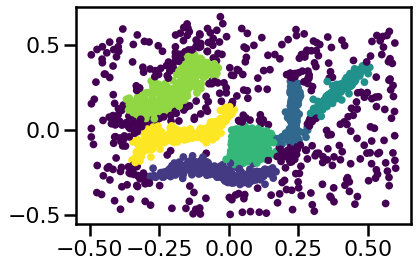

In [21]:
plt.figure()
plt.scatter(test_data_1.T[0], test_data_1.T[1], c = dbscan_labels, **plot_kwds)
plt.show()

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

In [22]:
import hdbscan

clusterer = hdbscan.HDBSCAN(metric='chebyshev')

clusterer.fit(test_data_1)

hdb_labels = clusterer.labels_

<Figure size 432x288 with 0 Axes>

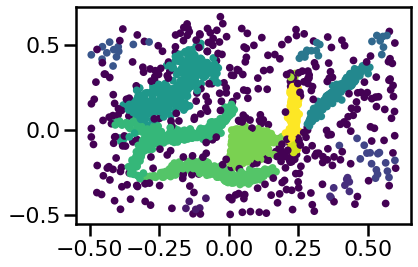

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure()
plt.scatter(test_data_1[:, 0], test_data_1[:, 1], c = hdb_labels, **plot_kwds)
plt.figure()

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


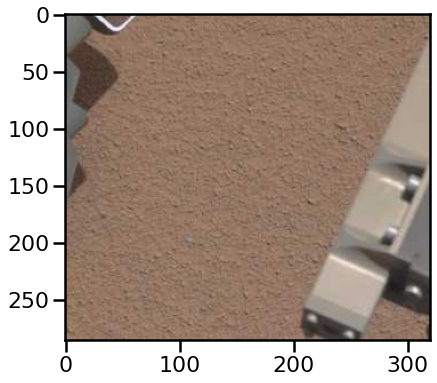

In [24]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

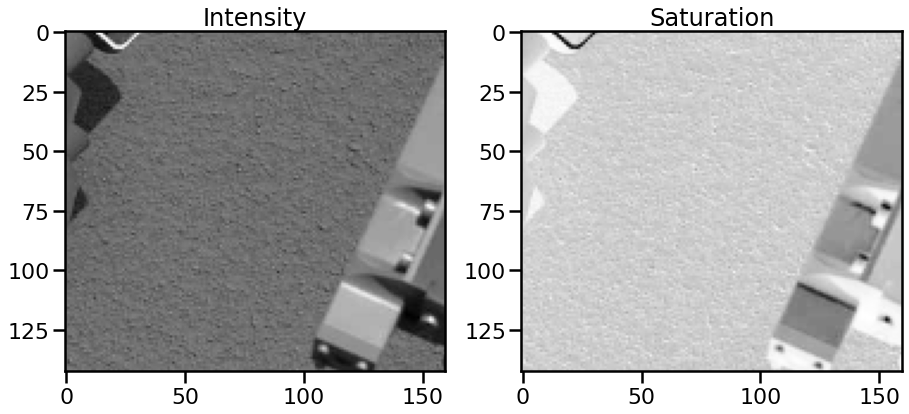

In [25]:
# The image array didn't fit into memory for hierarchical clustering so I divided its size by two.

array = np.array(Im_1)

array = array[::2, ::2, :]

I = array.mean(axis = -1)/256
S = 1 - I*(array.min(axis = -1)/256)

fig, ax = plt.subplots(1, 2, figsize = (15, 20))
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Intensity')
ax[1].imshow(S, cmap = 'gray')
ax[1].set_title('Saturation')
plt.show()

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

In [26]:
data = np.stack((I.flatten(), S.flatten()), axis = 1)
print('dataframe shape : ', data.shape)

dataframe shape :  (22880, 2)


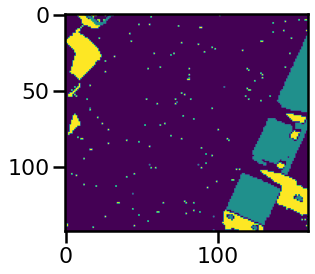

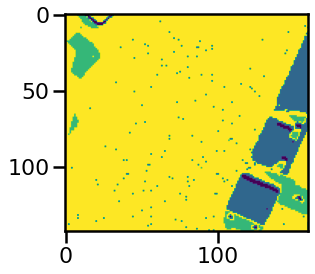

In [27]:
# Using kmeans.
plt.figure()
kmeans_0 = KMeans(n_clusters=3, max_iter=200).fit(data)
img = kmeans_0.labels_.reshape(array.shape[:2])
img = img/img.max()

plt.imshow(img)
plt.show()


# Using hierarchical clustering.
average = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'average').fit(data).labels_
img_2 = average.reshape(array.shape[:2])
img_2 = img_2/img_2.max()
plt.figure()
plt.imshow(img_2)
plt.show()

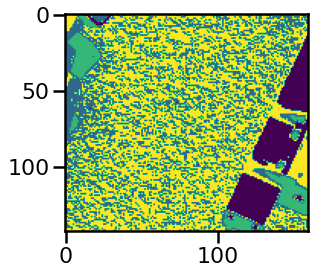

In [28]:
average = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward').fit(data).labels_
img_4 = average.reshape(array.shape[:2])
img_4 = img_4/img_4.max()
plt.figure()
plt.imshow(img_4)
plt.show()

In [29]:
clusterer = hdbscan.HDBSCAN(algorithm = 'boruvka_kdtree', metric='chebyshev')

clusterer.fit(data)

hdb_labels = clusterer.labels_

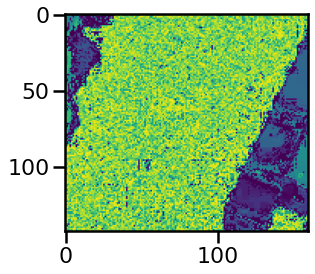

In [30]:
img_3 = hdb_labels.reshape(array.shape[:2])
img_3 = img_3/img_3.max()
plt.figure()
plt.imshow(img_3)
plt.show()

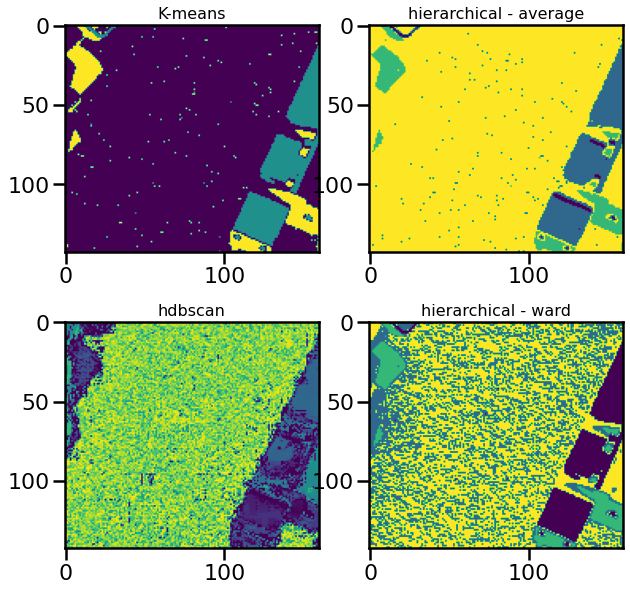

In [31]:


fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0][0].imshow(img)
ax[0][0].set_title('K-means', size=16)

ax[0][1].imshow(img_2)
ax[0][1].set_title('hierarchical - average', size=16)
# ax[0].set_title('')

ax[1][0].imshow(img_3)
ax[1][0].set_title('hdbscan', size=16)

ax[1][1].imshow(img_4)
ax[1][1].set_title('hierarchical - ward', size=16)

plt.show()

It seems that simpler methods such as kmeans and hierarchical clustering with a complete linkage do a better job of separating relevant features than hdbscan for example.

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

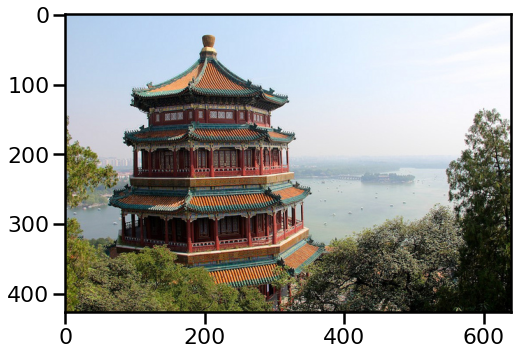

In [32]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

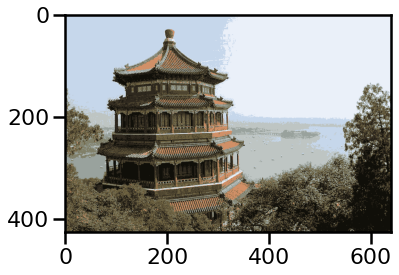

In [33]:
data = china.reshape((-1, 3))

plt.figure()
kmeans = KMeans(n_clusters=10, max_iter=200).fit(data)
image = np.zeros(china.shape)
img = kmeans.labels_.reshape(china.shape[:2])

# map each pixel to its corresponding centroid color.
clusters = np.unique(img)
centroids = kmeans.cluster_centers_
for c in clusters:
    map_ = np.where(img == c)
    color = centroids[c, :].astype(int)
    image[map_] = color

plt.imshow(image.astype(int))
plt.show()
